In [1]:
import sys
sys.path.append('../scripts')

import yaml
import torch
from argparse import Namespace

from runner import Runner

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open('/home/jupyter/rfcx_submission/config/training_config.yaml', 'r') as f:
    args= yaml.load(f,  yaml.FullLoader)

In [4]:
args= Namespace(**args)

In [5]:
runner= Runner(device, args)

In [6]:
runner.set_data_loader()

training: number of docs : 378
evaluation: number of docs : 378


In [7]:
runner.set_model()

In [8]:
batch = runner.dls.one_batch()
X,Y = batch

In [9]:
len(X)

3

In [10]:

import matplotlib.pyplot as plt


In [11]:
def plot_spectrogram_to_numpy(spectrogram):
    spectrogram = spectrogram.transpose(1, 0)
    fig, ax = plt.subplots(figsize=(18, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",cmap='magma')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.tight_layout()

    fig.canvas.draw()


In [12]:
z= runner.model(X)

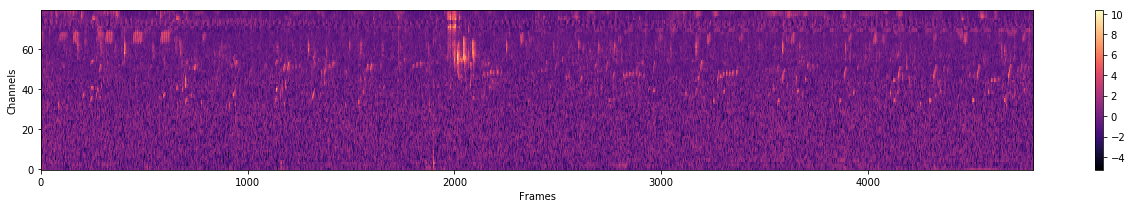

In [13]:
plot_spectrogram_to_numpy(X[0][0].detach().numpy())

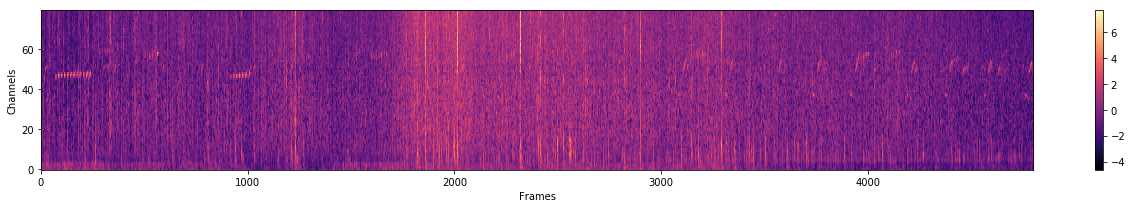

In [14]:
plot_spectrogram_to_numpy(X[0][1].detach().numpy())

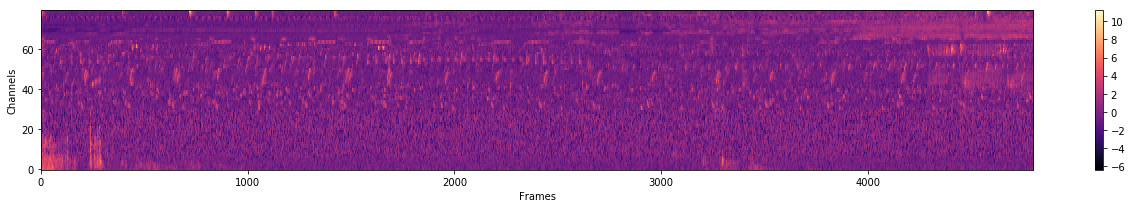

In [15]:
plot_spectrogram_to_numpy(X[0][2].detach().numpy())